![Logo AIED26](../assets/logo_AIED26.png)

# **Notebook#03 : Analysis on RQ2**
## [impact on help seeking and post-feedback actions]

## 1/ Imports

In [1]:
# Internal
import sys
sys.path.append("../src")
import students_constants as stu_const
import interaction_constants as int_const
import tests_constants  as tes_const
import session_date_constants as ses_const

# External
import pandas as pd
from scipy import stats
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt

## 2/ Data importation

In [2]:
interaction_data = pd.read_pickle("../data/interim/interaction_data.pkl")
pre_test_data = pd.read_pickle("../data/interim/pre_test_data.pkl")
post_test_data = pd.read_pickle("../data/interim/post_test_data.pkl")

## 3/ Digital assistant usage [B/C]

### 3.1/ Number of assistant call by game

How many times do students use the digital assistant on average per game depending on the groups?

In [3]:
# Filter only groups B and C
groups_BC_interaction = interaction_data[
    interaction_data[int_const.GROUP_ID_DATA_KEY].isin([int_const.GROUP_B, int_const.GROUP_C])
]

# Filter only assistant help received events
assistant_calls = groups_BC_interaction[
    (groups_BC_interaction[int_const.ACTION_DATA_KEY] == int_const.RECEIVED_ACTION) &
    (groups_BC_interaction[int_const.OBJECT_DATA_KEY] == int_const.ASSISTANT_HELP_OBJECT)
].copy()

# Get all game_id for groups B and C
all_games = groups_BC_interaction[[int_const.GROUP_ID_DATA_KEY, int_const.GAME_ID_DATA_KEY]].drop_duplicates()

# Count number of assistant calls per game
calls_count = assistant_calls.groupby([int_const.GROUP_ID_DATA_KEY, int_const.GAME_ID_DATA_KEY]).size().reset_index(name='num_calls')

# Merge with all games to include games with 0 calls
calls_per_game_group = pd.merge(all_games, calls_count, on=[int_const.GROUP_ID_DATA_KEY, int_const.GAME_ID_DATA_KEY], how='left')

# Replace NaN (games with no calls) by 0
calls_per_game_group['num_calls'] = calls_per_game_group['num_calls'].fillna(0).astype(int)

# Export to Excel for debug
calls_per_game_group.to_excel("../debug/debug_calls_to_assistant_per_game.xlsx")


# Separate B and C
calls_B = calls_per_game_group[calls_per_game_group['group_id'] == 'B']['num_calls']
calls_C = calls_per_game_group[calls_per_game_group['group_id'] == 'C']['num_calls']

# Combine B + C if desired
calls_BC = pd.concat([calls_B, calls_C])

# Descriptive statistics
mean_B = calls_B.mean()
std_B = calls_B.std()
mean_C = calls_C.mean()
std_C = calls_C.std()

difference_BC = mean_B - mean_C
percent_reduction = (difference_BC / mean_B) * 100

print("=== DESCRIPTIVE STATISTICS ===")
print(f"Group B (n={len(calls_B)}): M = {mean_B:.2f}, SD = {std_B:.2f}")
print(f"Group C (n={len(calls_C)}): M = {mean_C:.2f}, SD = {std_C:.2f}")
print(f".   Difference (B - C): {difference_BC:.2f}")
print(f".   Percent reduction from B to C: {percent_reduction:.2f}%")

=== DESCRIPTIVE STATISTICS ===
Group B (n=94): M = 15.79, SD = 11.88
Group C (n=73): M = 13.78, SD = 15.16
.   Difference (B - C): 2.01
.   Percent reduction from B to C: 12.71%


In [4]:
# TODO SL

## 4/ Teacher solicitation [A/B/C]

### 4.1/ Teacher solicitation calculation

In [5]:
# Process all groups in one go
groups = [int_const.GROUP_A, int_const.GROUP_B, int_const.GROUP_C]
calls_data = {}

for group in groups:
    # Filter and count teacher calls
    group_data = interaction_data[interaction_data[int_const.GROUP_ID_DATA_KEY] == group]
    
    teacher_calls = group_data[
        (group_data[int_const.ACTION_DATA_KEY] == int_const.RECEIVED_ACTION) &
        (group_data[int_const.OBJECT_DATA_KEY] == int_const.TEACHER_HELP_OBJECT)
    ]
    
    # Count per student
    calls_per_student = teacher_calls.groupby(int_const.GAME_ID_DATA_KEY).size()
    
    # Get valid students and fill missing with 0
    valid_students = [s[stu_const.GAME_ID] for s in stu_const.ALL_STUDENTS if s[stu_const.GROUP_ID] == group]
    calls_per_student = calls_per_student.reindex(valid_students, fill_value=0)
    
    calls_data[group] = calls_per_student
    print(f"Group {group}: {len(calls_per_student)} students processed")
    
    # Export
    calls_per_student.to_excel(f"../debug/debug_teacher_solicitation_per_student_{group}.xlsx")

Group A: 81 students processed
Group B: 94 students processed
Group C: 73 students processed


### 4.2/ Test A VS (B+C)

Is there a difference in teacher solicitation between students from group A and students from group B+C ?

In [6]:
# Extract calls data for each group
calls_A = calls_data['A']
calls_B = calls_data['B']
calls_C = calls_data['C']

# Combine B and C groups
calls_BC = pd.concat([calls_B, calls_C])

# Descriptive statistics
mean_A = calls_A.mean()
mean_BC = calls_BC.mean()
std_A = calls_A.std()
std_BC = calls_BC.std()
diff_A_BC = mean_A - mean_BC
percent_reduction_BC = (diff_A_BC / mean_A) * 100

print("\n=== DESCRIPTIVE STATISTICS ===")
print(f"Group A (n={len(calls_A)}): M = {mean_A:.2f}, SD = {std_A:.2f}")
print(f"Group B+C (n={len(calls_BC)}): M = {mean_BC:.2f}, SD = {std_BC:.2f}")
print(f".   Difference (A - B+C) = {diff_A_BC:.2f}")
print(f".   Percentage reduction compared to A = {percent_reduction_BC:.2f}%")


=== DESCRIPTIVE STATISTICS ===
Group A (n=81): M = 1.96, SD = 1.85
Group B+C (n=167): M = 1.47, SD = 1.94
.   Difference (A - B+C) = 0.49
.   Percentage reduction compared to A = 24.96%


In [7]:
# TODO SL

### 4.3/ Test A VS B VS C

Is there a difference in teacher solicitation between students from groups A, B, and C?

In [8]:
# Descriptive statistics
average_calls_A = calls_A.mean()
average_calls_B = calls_B.mean()
average_calls_C = calls_C.mean()

diff_B_A = average_calls_A - average_calls_B
diff_C_A = average_calls_A - average_calls_C

percent_reduction_B = (diff_B_A / average_calls_A) * 100
percent_reduction_C = (diff_C_A / average_calls_A) * 100

print("\n=== DESCRIPTIVE STATISTICS ===")
print(f"Group A (n={len(calls_A)}): M = {average_calls_A:.2f}, SD = {calls_A.std():.2f}")
print(f"Group B (n={len(calls_B)}): M = {average_calls_B:.2f}, SD = {calls_B.std():.2f}")
print(f".   B vs A: Difference = {diff_B_A:.2f}, Percentage reduction = {percent_reduction_B:.2f}%")
print(f"Group C (n={len(calls_C)}): M = {average_calls_C:.2f}, SD = {calls_C.std():.2f}")
print(f".   C vs A: Difference = {diff_C_A:.2f}, Percentage reduction = {percent_reduction_C:.2f}%")


=== DESCRIPTIVE STATISTICS ===
Group A (n=81): M = 1.96, SD = 1.85
Group B (n=94): M = 1.53, SD = 2.20
.   B vs A: Difference = 0.43, Percentage reduction = 21.96%
Group C (n=73): M = 1.40, SD = 1.57
.   C vs A: Difference = 0.57, Percentage reduction = 28.82%


In [9]:
# TODO SL

## 5/ Activity following feedback [B/C]

### 5.1/ Calculation of student activity following feedback

1/ Following a request to the digital assistant, we categorize the subsequent sequence into four categories:
- `progression`: the student managed to progress in the game (first increment of game_progression or reach of next level) without calling the teacher or the digital assistant again
- `teacher_call`: the student requested help from the teacher (without having progressed in the game)
- `assistant_call`: the student requested help from the digital assistant again (without having progressed in the game)
- `other`: other cases, for example, the experiment ends

Note that we do not have in the traces the start date of teacher interventions but only the end date. This is why, when we detect a progression in a sequence, we search in the following 120 seconds for a trace of the end of a teacher intervention. If we find one, we reclassify the sequence as `teacher_call`.

2/ Moreover, when a progression sequence occurs, we compute:
- the progression gain (difference in game_progression)
- the sequence of actions before the progression occurred (see `categorize_action()` function bellow)

In [10]:
# Filter for groups B and C
groups_BC_interaction = interaction_data[
    interaction_data[int_const.GROUP_ID_DATA_KEY].isin([int_const.GROUP_B, int_const.GROUP_C])
]

# Sort by student and date to analyze sequences
groups_BC_interaction = groups_BC_interaction.sort_values([
    int_const.GAME_ID_DATA_KEY, 
    int_const.DATE_DATA_KEY
]).reset_index(drop=True)

# Filter all feedback reception events
feedback_events = groups_BC_interaction[
    (groups_BC_interaction[int_const.ACTION_DATA_KEY] == int_const.RECEIVED_ACTION) &
    (groups_BC_interaction[int_const.OBJECT_DATA_KEY] == int_const.ASSISTANT_HELP_OBJECT)
].copy()


# Define action categories
def categorize_action(row):
    action = row[int_const.ACTION_DATA_KEY]
    object_name = row[int_const.OBJECT_DATA_KEY]
    # Display of the memo
    if action == int_const.DISPLAYED_ACTION:
        return "memo_displayed"
    # Copy of feedback content
    elif (action == int_const.COPIED_ACTION and 
          object_name == int_const.ASSISTANT_MESSAGES_SECTION_OBJECT):
        return "feedback_content_copied"
    # Copy of the memo content
    elif (action == int_const.COPIED_ACTION and 
          object_name in [
              int_const.BASE_PROGRAM_SECTION_OBJECT,
              int_const.BASE_ERROR_SECTION_OBJECT,
              int_const.BASE_STRUCTURE_SECTION_OBJECT,
              int_const.BASE_COMMENT_SECTION_OBJECT,
              int_const.VAR_CREATION_SECTION_OBJECT,
              int_const.VAR_MODIFICATION_SECTION_OBJECT,
              int_const.VAR_USAGE_SECTION_OBJECT,
              int_const.VAR_TYPE_SECTION_OBJECT,
              int_const.CONDI_1BRAN_SECTION_OBJECT,
              int_const.CONDI_2BRAN_SECTION_OBJECT,
              int_const.CONDI_3BRAN_SECTION_OBJECT,
              int_const.FOR_SIMPLE_SECTION_OBJECT,
              int_const.FOR_COUNTER_0_SECTION_OBJECT,
              int_const.FOR_COUNTER_N_SECTION_OBJECT,
              int_const.WHILE_SIMPLE_SECTION_OBJECT
          ]):
        return "memo_content_copied"
    # Copy of code editor
    elif (action == int_const.COPIED_ACTION and 
          object_name == int_const.CODE_EDITOR_SECTION_OBJECT):
        return "code_editor_copied"
    # Copy of control function
    elif (action == int_const.COPIED_ACTION and 
          object_name == int_const.CONTROL_FUNCTION_SECTION_OBJECT):
        return "control_function_copied"
    # Code paste
    elif action == int_const.PASTED_ACTION:
        return "code_pasted"
    # Launch of a correct program
    elif (action == int_const.LAUNCHED_ACTION and 
          object_name in [
              int_const.FULLY_EXECUTED_PROGRAM_OBJECT,
              int_const.LEVEL_COMPLETED_PROGRAM_OBJECT
          ]):
        return "correct_program_launched"
    # Launch of an erroneous program
    elif (action == int_const.LAUNCHED_ACTION and 
          object_name in [
              int_const.LEVEL_LOST_PROGRAM_OBJECT,
              int_const.TOO_MANY_LINES_ERROR_PROGRAM_OBJECT,
              int_const.GAME_ERROR_PROGRAM_OBJECT,
              int_const.SYNTACTIC_ERROR_PROGRAM_OBJECT,
              int_const.SEMANTIC_ERROR_PROGRAM_OBJECT
          ]):
        # return "erroneous_program_launched"
        return "error_program_launched"
    # Launch of a stopped program
    elif (action == int_const.LAUNCHED_ACTION and 
          object_name == int_const.USER_STOPPED_PROGRAM_OBJECT):
        # return "stopped_program_launched"
        return "program_stopped"
    # Leave to visit a completed level
    elif action == int_const.LEAVED_ACTION:
        return "level_leaved"
    # Back from a completed level
    elif action in [int_const.RESUMED_ACTION, int_const.RESTARTED_ACTION]:
        return "level_resumed"
    # End of the level (not a real action)
    elif action == int_const.ENDED_ACTION:
        return "level_ended"
    # Assistant help called
    elif (action == int_const.ASKED_ACTION and 
          object_name == int_const.ASSISTANT_HELP_OBJECT):
        return "assistant_help_called"
    # Assistant help received
    elif (action == int_const.RECEIVED_ACTION and 
          object_name == int_const.ASSISTANT_HELP_OBJECT):
        return "assistant_help_received"
    # Teacher help received
    elif (action == int_const.RECEIVED_ACTION and 
          object_name == int_const.TEACHER_HELP_OBJECT):
        return "teacher_help_received"
    # Change of speed cursor
    elif (action == int_const.CHANGED_ACTION and 
          object_name == int_const.EXECUTION_SPEED_SLIDE_OBJECT):
        return "speed_cursor_changed"
    else:
        return "other"


feedback_analysis = []
# Iterate on each feedback event
for _, feedback in feedback_events.iterrows():
    game_id = feedback[int_const.GAME_ID_DATA_KEY]
    group_id = feedback[int_const.GROUP_ID_DATA_KEY]
    feedback_date = feedback[int_const.DATE_DATA_KEY]
    feedback_level = feedback[int_const.LEVEL_DATA_KEY]
    feedback_progression = feedback[int_const.GAME_PROGRESSION_DATA_KEY]
    
    # Get student's traces after this feedback
    student_traces = groups_BC_interaction[
        (groups_BC_interaction[int_const.GAME_ID_DATA_KEY] == game_id) &
        (groups_BC_interaction[int_const.DATE_DATA_KEY] > feedback_date)
    ]
    
    actions_after_feedback = []
    sequence_outcome = "other"  # Default outcome
    progression_gain = 0  # Initialize progression gain
    progression_date = None  # Track when progression happened
    
    # Iterate on post-feedback traces
    for _, trace in student_traces.iterrows():
        current_progression = trace[int_const.GAME_PROGRESSION_DATA_KEY]
        current_level = trace[int_const.LEVEL_DATA_KEY]
        
        # Check for teacher call progression
        if (trace[int_const.ACTION_DATA_KEY] == int_const.RECEIVED_ACTION and 
            trace[int_const.OBJECT_DATA_KEY] == int_const.TEACHER_HELP_OBJECT):
            sequence_outcome = "teacher_call"
            break
        
        # Check for new assistant call progression
        if (trace[int_const.ACTION_DATA_KEY] == int_const.ASKED_ACTION and 
            trace[int_const.OBJECT_DATA_KEY] == int_const.ASSISTANT_HELP_OBJECT):
            sequence_outcome = "assistant_call"
            break
        
        # Check if progression increased (in same level) or level increased
        progression_increase = (current_level == feedback_level and 
                               current_progression > feedback_progression)
        level_increase = current_level > feedback_level

        # Check if progression achieved
        if progression_increase or level_increase:
            sequence_outcome = "progression"
            # Calculate progression gain
            if level_increase:
                progression_gain = 100 - feedback_progression
            else:
                progression_gain = current_progression - feedback_progression
            
            # Store the date when progression happened
            progression_date = trace[int_const.DATE_DATA_KEY]
            
            # We break without adding the action that make progression detection
            # That's because in the Pyrates trace system, the progression is reported in the next trace
            # i.e. each trace report the progression before its action
            break
        
        # Categorize and count all sequence actions
        action_type = categorize_action(trace)
        # Ignore level_end which is not really an action
        if action_type not in ["level_ended"]:
            actions_after_feedback.append(action_type)
    
    # Check for teacher call within 120 seconds after detected progression
    if sequence_outcome == "progression" and progression_date is not None:
        # Look for teacher help in the 120 seconds following progression
        teacher_help_after_progression = groups_BC_interaction[
            (groups_BC_interaction[int_const.GAME_ID_DATA_KEY] == game_id) &
            (groups_BC_interaction[int_const.DATE_DATA_KEY] > progression_date) &
            (groups_BC_interaction[int_const.DATE_DATA_KEY] <= progression_date + pd.Timedelta(seconds=120)) &
            (groups_BC_interaction[int_const.ACTION_DATA_KEY] == int_const.RECEIVED_ACTION) &
            (groups_BC_interaction[int_const.OBJECT_DATA_KEY] == int_const.TEACHER_HELP_OBJECT)
        ]
        
        if not teacher_help_after_progression.empty:
            sequence_outcome = "teacher_call"
    
    # Store analysis for this feedback event
    feedback_analysis.append({
        'game_id': game_id,
        'group': group_id,
        'feedback_level': feedback_level,
        'feedback_progression': feedback_progression,
        'actions_count': len(actions_after_feedback),
        'actions_sequence': actions_after_feedback,
        'sequence_outcome': sequence_outcome,
        'progression_gain': progression_gain,
    })

# Convert to DataFrame
analysis_df = pd.DataFrame(feedback_analysis)
# Export
analysis_df.to_excel(f"../debug/debug_activity_following_feedback.xlsx")

print(f"Total sequences analyzed: {len(feedback_analysis)}")

Total sequences analyzed: 2490


### 5.2/ Feedback outcomes

What is the outcome of the action sequences following the reception of feedback depending on the groups?

In [11]:
alpha = 0.05
groups = [int_const.GROUP_B, int_const.GROUP_C]
categories = ['assistant_call', 'progression', 'teacher_call', 'other']


# Store counts, totals, and significance
counts_dict = {}
totals_dict = {}
significant_flags = {}

# Print feedback outcomes per group
for group in groups:
    group_data = analysis_df[analysis_df['group'] == group]
    
    print(f"\n=======================================")
    print(f"GROUP {group} FEEDBACK OUTCOMES")
    print(f"========================================")
    print(f"Total feedback sequences: {len(group_data)}")
    
    outcome_counts = group_data['sequence_outcome'].value_counts()
    counts_dict[group] = np.array([outcome_counts.get(cat, 0) for cat in categories])
    totals_dict[group] = len(group_data)
    
    for outcome in categories:
        count = outcome_counts.get(outcome, 0)
        percentage = (count / len(group_data)) * 100
        print(f"   {outcome}: {count} sequences ({percentage:.1f}%)")

# Contingency table for Chi-square test
contingency_table = np.array([counts_dict[int_const.GROUP_B], counts_dict[int_const.GROUP_C]]).T

chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)
print("\n=== Chi-square Test (B vs C) ===")
print(f"Chi2 statistic = {chi2:.2f}, p-value = {p_chi2:.4f}")

# Z-tests for proportions per category (Bonferroni correction)
print("\n=== Z-test for proportions by category ===")
n_B = totals_dict[int_const.GROUP_B]
n_C = totals_dict[int_const.GROUP_C]
num_tests = len(categories)

for i, category in enumerate(categories):
    counts_i = np.array([counts_dict[int_const.GROUP_B][i], counts_dict[int_const.GROUP_C][i]])
    nobs = np.array([n_B, n_C])
    
    stat, pval = proportions_ztest(counts_i, nobs)
    adjusted_p = min(pval * num_tests, 1.0)  # Bonferroni correction
    significance = adjusted_p < alpha
    significant_flags[category] = significance 
    
    label = "SIGNIFICANT" if significance else "not significant"
    print(f"{category}: Z = {stat:.2f}, raw p-value = {pval:.4f}, adjusted p-value = {adjusted_p:.4f} -> {label}")


print("\nOverall interpretation:")
if p_chi2 < alpha:
    print("The overall distribution of actions following feedback differs significantly between B and C.")
else:
    print("No significant overall difference between B and C.")



GROUP B FEEDBACK OUTCOMES
Total feedback sequences: 1484
   assistant_call: 829 sequences (55.9%)
   progression: 528 sequences (35.6%)
   teacher_call: 87 sequences (5.9%)
   other: 40 sequences (2.7%)

GROUP C FEEDBACK OUTCOMES
Total feedback sequences: 1006
   assistant_call: 593 sequences (58.9%)
   progression: 334 sequences (33.2%)
   teacher_call: 60 sequences (6.0%)
   other: 19 sequences (1.9%)

=== Chi-square Test (B vs C) ===
Chi2 statistic = 3.64, p-value = 0.3036

=== Z-test for proportions by category ===
assistant_call: Z = -1.53, raw p-value = 0.1271, adjusted p-value = 0.5084 -> not significant
progression: Z = 1.22, raw p-value = 0.2208, adjusted p-value = 0.8834 -> not significant
teacher_call: Z = -0.11, raw p-value = 0.9159, adjusted p-value = 1.0000 -> not significant
other: Z = 1.30, raw p-value = 0.1940, adjusted p-value = 0.7761 -> not significant

Overall interpretation:
No significant overall difference between B and C.


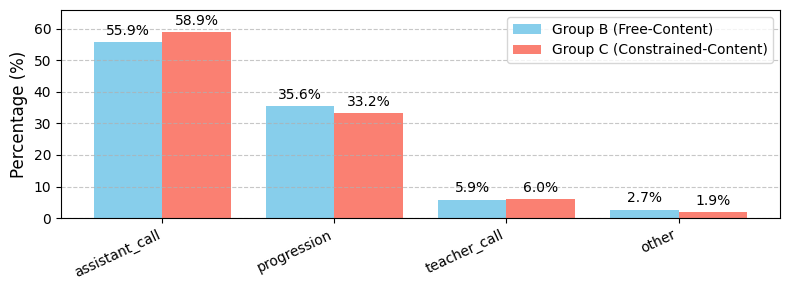

In [12]:
top_n_plot = 4 
groups = [int_const.GROUP_B, int_const.GROUP_C]

# Slice precomputed results
display_categories = categories[:top_n_plot]
percentage_df_plot = pd.DataFrame(index=display_categories, columns=groups, dtype=float)

for cat in display_categories:
    for group in groups:
        total = totals_dict[group]
        count = counts_dict[group][categories.index(cat)]
        percentage_df_plot.loc[cat, group] = (count / total) * 100 if total > 0 else 0

# X positions
x = np.arange(len(display_categories))
width = 0.4

# Plot
fig, ax = plt.subplots(figsize=(8, 3))
bars_B = ax.bar(x - width/2, percentage_df_plot[int_const.GROUP_B], width, label='Group B (Free-Content)', color='skyblue')
bars_C = ax.bar(x + width/2, percentage_df_plot[int_const.GROUP_C], width, label='Group C (Constrained-Content)', color='salmon')

ax.set_xticks(x)
ax.set_xticklabels(display_categories, rotation=25, ha='right')
# ax.set_xlabel("Feedback outcome", fontsize=12)
ax.set_ylabel("Percentage (%)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(0, max(percentage_df_plot.max()) + 7)

# Add percentage labels and significance stars
for i, cat in enumerate(display_categories):
    height_B = percentage_df_plot[int_const.GROUP_B][cat]
    height_C = percentage_df_plot[int_const.GROUP_C][cat]
    
    # Labels on top of each bar
    ax.annotate(f'{height_B:.1f}%', xy=(x[i] - width/2, height_B), xytext=(0,3),
                textcoords="offset points", ha='center', va='bottom', fontsize=10)
    ax.annotate(f'{height_C:.1f}%', xy=(x[i] + width/2, height_C), xytext=(0,3),
                textcoords="offset points", ha='center', va='bottom', fontsize=10)
    
    # Add significance star above bars if precomputed as significant
    if significant_flags[cat]:
        y_star = max(height_B, height_C) + 3
        ax.text(x[i], y_star, '*', ha='center', va='bottom', fontsize=16, color='black')

# Legend and layout
ax.legend()
plt.tight_layout()
plt.savefig("../outputs/feedback_outcomes_BC.png", dpi=300, bbox_inches="tight")
plt.show()


### 5.3/ Number of actions before progression

How many actions do students need to achieve a progression in the game following feedback depending on the groups?

In [13]:
# Extract progression-only data
progress_B = analysis_df[(analysis_df['group'] == int_const.GROUP_B) & 
                         (analysis_df['sequence_outcome'] == 'progression')]

progress_C = analysis_df[(analysis_df['group'] == int_const.GROUP_C) & 
                         (analysis_df['sequence_outcome'] == 'progression')]

data_B = progress_B["actions_count"].dropna()
data_C = progress_C["actions_count"].dropna()

# Descriptive statistics
mean_B = data_B.mean()
mean_C = data_C.mean()
std_B = data_B.std()
std_C = data_C.std()

# Difference in means
mean_difference = mean_C - mean_B
# Percentage increase (relative to group B)
percent_increase = (mean_difference / mean_B) * 100

print("=== DESCRIPTIVE STATISTICS ===")
print(f"Group B (n={len(data_B)}): M = {mean_B:.2f}, SD = {std_B:.2f}")
print(f"Group C (n={len(data_C)}): M = {mean_C:.2f}, SD = {std_C:.2f}")
print(f".   Difference (C - B): {mean_difference:.2f}")
print(f".   Percentage increase from B to C: {percent_increase:.2f}%")

alpha = 0.05
# Normality test
print("\n=== NORMALITY TESTS (Shapiro-Wilk) ===")
shapiro_B = stats.shapiro(data_B)
shapiro_C = stats.shapiro(data_C)
print(f"Group B: p-value = {shapiro_B.pvalue:.4f} -> "
        f"{'normally distributed' if shapiro_B.pvalue >= alpha else 'not normally distributed'}")
print(f"Group C: p-value = {shapiro_C.pvalue:.4f} -> "
        f"{'normally distributed' if shapiro_C.pvalue >= alpha else 'not normally distributed'}")

# Levene test
print("\n=== HOMOGENEITY OF VARIANCES (Levene) ===")
levene_p = stats.levene(data_B, data_C).pvalue

print(f"Levene p-value = {levene_p:.4f} -> "
        f"{'variances are similar' if levene_p >= alpha else 'variances differ'}")

print(f"\n=== TEST RESULTS ===")
# Choose appropriate test
normal_B = shapiro_B.pvalue >= alpha
normal_C = shapiro_C.pvalue >= alpha
equal_var = levene_p >= alpha

if normal_B and normal_C and equal_var:
    print("Using independent t-test (parametric)")
    stat, p_value = stats.ttest_ind(data_B, data_C, equal_var=True)
    # Cohen's d
    n1, n2 = len(data_B), len(data_C)
    pooled_std = np.sqrt(((n1 - 1) * std_B**2 + (n2 - 1) * std_C**2) / (n1 + n2 - 2))
    cohens_d = (mean_C - mean_B) / pooled_std
    
    print(f"Test statistic (t) = {stat:.4f}")
    print(f"P-value = {p_value:.4f}")
    print(f"Cohen's d = {cohens_d:.4f}")
    
    if abs(cohens_d) < 0.2:
        effect_label = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_label = "small"
    elif abs(cohens_d) < 0.8:
        effect_label = "medium"
    else:
        effect_label = "large"
    print(f"Effect size: {effect_label}")

else:
    print("Using Mann-Whitney U test (non-parametric)")
    stat, p_value = stats.mannwhitneyu(data_B, data_C, alternative='two-sided')
    # Effect size r = Z / sqrt(N)
    n_total = len(data_B) + len(data_C)
    z_score = stats.norm.ppf(1 - p_value / 2)  # two-tailed
    r_effect = abs(z_score) / np.sqrt(n_total)
    
    print(f"Test statistic (U) = {stat:.4f}")
    print(f"P-value = {p_value:.4f}")
    print(f"Effect size (r) = {r_effect:.4f}")
    
    if r_effect < 0.1:
        effect_label = "negligible"
    elif r_effect < 0.3:
        effect_label = "small"
    elif r_effect < 0.5:
        effect_label = "medium"
    else:
        effect_label = "large"
    print(f"Effect size: {effect_label}")


if p_value < alpha:
    print(f"SIGNIFICANT difference: p = {p_value:.4f} < {alpha}")
else:
    print(f"No significant difference: p = {p_value:.4f} >= {alpha}")


=== DESCRIPTIVE STATISTICS ===
Group B (n=528): M = 6.64, SD = 10.75
Group C (n=334): M = 9.24, SD = 13.26
.   Difference (C - B): 2.60
.   Percentage increase from B to C: 39.14%

=== NORMALITY TESTS (Shapiro-Wilk) ===
Group B: p-value = 0.0000 -> not normally distributed
Group C: p-value = 0.0000 -> not normally distributed

=== HOMOGENEITY OF VARIANCES (Levene) ===
Levene p-value = 0.0139 -> variances differ

=== TEST RESULTS ===
Using Mann-Whitney U test (non-parametric)
Test statistic (U) = 72303.5000
P-value = 0.0000
Effect size (r) = 0.1534
Effect size: small
SIGNIFICANT difference: p = 0.0000 < 0.05


### 5.4/ Action distribution in progression sequences

What type of actions do students perform before achieving a progression in the game following feedback depending on the groups?

In [14]:
top_n_display = 10
groups = [int_const.GROUP_B, int_const.GROUP_C]
alpha = 0.05

# Collect all progression actions across both groups
all_actions_overall = []
for group in groups:
    group_data = analysis_df[(analysis_df['group'] == group) & 
                             (analysis_df['sequence_outcome'] == 'progression')]
    for seq in group_data['actions_sequence']:
        all_actions_overall.extend(seq)

# Determine global top-k actions
overall_counts = pd.Series(all_actions_overall).value_counts()
top_actions_global = overall_counts.head(top_n_display).index.tolist()
print(f"Global Top-{top_n_display} actions: {top_actions_global}")

# Prepare counts and percentages per group
percentage_df = pd.DataFrame(index=top_actions_global, columns=groups, dtype=float)
counts_dict = {}
totals_dict = {}
significant_flags = {}

for group in groups:
    group_data = analysis_df[(analysis_df['group'] == group) & 
                             (analysis_df['sequence_outcome'] == 'progression')]
    group_actions = []
    for seq in group_data['actions_sequence']:
        group_actions.extend(seq)
    
    action_counts = pd.Series(group_actions).value_counts()
    total_actions = len(group_actions)
    
    counts_dict[group] = np.array([action_counts.get(act, 0) for act in top_actions_global])
    totals_dict[group] = total_actions
    
    print(f"\n=============================")
    print(f"GROUP {group} ACTION DISTRIBUTION (Top {top_n_display})")
    print(f"=============================")
    for i, action in enumerate(top_actions_global):
        pct = (counts_dict[group][i] / total_actions) * 100 if total_actions > 0 else 0
        percentage_df.loc[action, group] = pct
        print(f"   {action}: {counts_dict[group][i]} times ({pct:.1f}%)")
    print(f"   Total actions analyzed: {total_actions}")

# Chi-square test across top actions
contingency_table = np.array([counts_dict[int_const.GROUP_B], counts_dict[int_const.GROUP_C]]).T
chi2, p_chi2, dof, expected = chi2_contingency(contingency_table)
print("\n=== Chi-square Test (B vs C) ===")
print(f"Chi2 statistic = {chi2:.2f}, p-value = {p_chi2:.4f}")

# Z-tests for top-k actions with Bonferroni correction
print("\n=== Z-test for proportions by top action (Bonferroni corrected) ===")
num_tests = len(top_actions_global)
for i, action in enumerate(top_actions_global):
    counts_i = np.array([counts_dict[int_const.GROUP_B][i], counts_dict[int_const.GROUP_C][i]])
    nobs = np.array([totals_dict[int_const.GROUP_B], totals_dict[int_const.GROUP_C]])
    
    stat, pval = proportions_ztest(counts_i, nobs)
    adjusted_p = min(pval * num_tests, 1.0)  # Bonferroni correction
    significance = adjusted_p < alpha
    significant_flags[action] = significance
    label = "SIGNIFICANT" if significance else "not significant"
    print(f"{action}: Z = {stat:.2f}, raw p-value = {pval:.4f}, adjusted p-value = {adjusted_p:.4f} -> {label}")

# Overall interpretation
print("\nOverall interpretation:")
if p_chi2 < alpha:
    print("The overall distribution of progression actions differs significantly between B and C.")
else:
    print("No significant overall difference between B and C.")


Global Top-10 actions: ['error_program_launched', 'correct_program_launched', 'memo_displayed', 'code_pasted', 'program_stopped', 'memo_content_copied', 'code_editor_copied', 'feedback_content_copied', 'level_resumed', 'control_function_copied']

GROUP B ACTION DISTRIBUTION (Top 10)
   error_program_launched: 1193 times (34.0%)
   correct_program_launched: 657 times (18.7%)
   memo_displayed: 555 times (15.8%)
   code_pasted: 322 times (9.2%)
   program_stopped: 299 times (8.5%)
   memo_content_copied: 154 times (4.4%)
   code_editor_copied: 57 times (1.6%)
   feedback_content_copied: 125 times (3.6%)
   level_resumed: 44 times (1.3%)
   control_function_copied: 27 times (0.8%)
   Total actions analyzed: 3505

GROUP C ACTION DISTRIBUTION (Top 10)
   error_program_launched: 931 times (30.2%)
   correct_program_launched: 526 times (17.1%)
   memo_displayed: 610 times (19.8%)
   code_pasted: 385 times (12.5%)
   program_stopped: 81 times (2.6%)
   memo_content_copied: 116 times (3.8%)
   

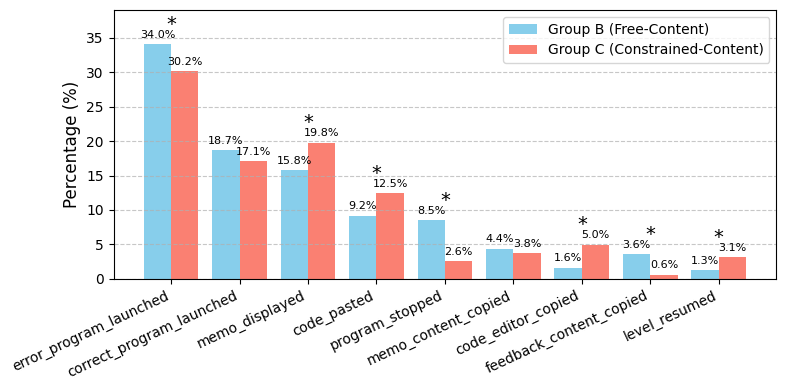

In [15]:
top_n_plot = 9  # number of top actions to display
groups = [int_const.GROUP_B, int_const.GROUP_C]

# Slice the precomputed results
display_actions = percentage_df.index[:top_n_plot]  # top actions to show
percentage_df_plot = percentage_df.loc[display_actions, groups]
significant_flags_plot = {action: significant_flags.get(action, False) for action in display_actions}

# X positions for the bars
x = np.arange(len(display_actions))
width = 0.4

# Plot
fig, ax = plt.subplots(figsize=(8, 4))

bars_B = ax.bar(x - width/2, percentage_df_plot[int_const.GROUP_B], width, label='Group B (Free-Content)', color='skyblue')
bars_C = ax.bar(x + width/2, percentage_df_plot[int_const.GROUP_C], width, label='Group C (Constrained-Content)', color='salmon')

ax.set_xticks(x)
ax.set_xticklabels(display_actions, rotation=25, ha='right')
# ax.set_xlabel("Action type", fontsize=12)
ax.set_ylabel("Percentage (%)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(0, max(percentage_df_plot.max()) + 5)

# Add percentage labels and significance stars
for i, action in enumerate(display_actions):
    height_B = percentage_df_plot[int_const.GROUP_B][action]
    height_C = percentage_df_plot[int_const.GROUP_C][action]
    
    # Labels on top of each bar
    ax.annotate(f'{height_B:.1f}%', xy=(x[i] - width/2, height_B), xytext=(0,3),
                textcoords="offset points", ha='center', va='bottom', fontsize=8)
    ax.annotate(f'{height_C:.1f}%', xy=(x[i] + width/2, height_C), xytext=(0,3),
                textcoords="offset points", ha='center', va='bottom', fontsize=8)
    
    # Add significance star centered between the bars
    if significant_flags_plot[action]:
        y_star = max(height_B, height_C) + 1.5
        ax.text(x[i], y_star, '*', ha='center', va='bottom', fontsize=14, color='black')

# Add legend and layout
ax.legend()
plt.tight_layout()
plt.savefig("../outputs/action_types_BC.png", dpi=300, bbox_inches="tight")
plt.show()
